# Obtaining Data

## Stakeholders 
The Seattle Police Department has reached out to determine the likelihood of Terry Stops preventing a crime by arresting suspects under the basis of "probable cause". In an effort to improve race relations, they also want to see how much of a role racial discrimination plays in who gets stopped.  

## Objectives: 
* Determine the likelihood of an arrest occurring during a Terry Stop
* Determine if there is a relationship between Terry Stops and a subject's race
* Do the differences in races of the police officer and the subject play a role?
* How do Terry Stops in Seattle compare to the circumstances around *Terry v. Ohio*?

Ok, let's check out this data!

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
df = pd.read_csv('CSV_Files/Terry_Stops.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,-,-,-,NaN,N,N,-,-,-


That's... A lot of missing data...

In [3]:
df.shape

(43512, 23)

We see a lot of place holder values, let's look for any NaNs in our dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43512 entries, 0 to 43511
Data columns (total 23 columns):
Subject Age Group           43512 non-null object
Subject ID                  43512 non-null int64
GO / SC Num                 43512 non-null int64
Terry Stop ID               43512 non-null int64
Stop Resolution             43512 non-null object
Weapon Type                 43512 non-null object
Officer ID                  43512 non-null object
Officer YOB                 43512 non-null int64
Officer Gender              43512 non-null object
Officer Race                43512 non-null object
Subject Perceived Race      43512 non-null object
Subject Perceived Gender    43512 non-null object
Reported Date               43512 non-null object
Reported Time               43512 non-null object
Initial Call Type           43512 non-null object
Final Call Type             43512 non-null object
Call Type                   43512 non-null object
Officer Squad               42968 non-null ob

Officer Squad has 544 NaN values.  To save time we'll make a function that shows us the value counts of each column

In [5]:
def col_values(df):
    """
    For use in Preprocessing and cleaning to find placeholder values
    Input: Data frame
    Output: Counts of unique values for each column
    """
    for col in df.columns:
        print(col)
        print('\n')
        print(df[col].value_counts())
        print('-------------------------------------------------------')
        print('\n')

In [6]:
col_values(df)

Subject Age Group


26 - 35         14420
36 - 45          9153
18 - 25          8875
46 - 55          5599
56 and Above     2185
1 - 17           1908
-                1372
Name: Subject Age Group, dtype: int64
-------------------------------------------------------


Subject ID


-1              34676
 7726859935        18
 7727117712        12
 7753260438        11
 7726318196         8
                ...  
 7730602336         1
 7758922092         1
 7727677812         1
 9640739188         1
 12095084261        1
Name: Subject ID, Length: 7045, dtype: int64
-------------------------------------------------------


GO / SC Num


20150000190790    16
20160000378750    16
20180000134604    14
20170000132836    13
20190000441736    13
                  ..
20190000076830     1
20150000379928     1
20180000002079     1
20180000333849     1
20180000071981     1
Name: GO / SC Num, Length: 33910, dtype: int64
-------------------------------------------------------


Terry Stop ID


130800

### Notes:
**Age Groups**: 1372 people with unknown age

**Subject ID**: 34,676 people that are not assigned an ID number, also some people stopped multiple times

**General Offense**: Repeated values, need to look into why

**Terry Stop ID**: Repeated values. These duplicates should definitely be removed.

**Stop Resolution**: No NaNs or place holders, but distinction needs to be made between physical and non-custodial arrest.

**Weapon Type**: Needs to be cleaned up and binned. Need to create 'unknown' to account for placeholders

**Officer ID**: Clean. This data may be irrelevant.

**Officer YOB**: Clean.

**Officer Gender**: 11 counts of 'N'.  Unable to determine if this means unknown, non-gender binary, etc.  It's a tiny amount of data, just drop it.

**Reported Date**: Clean; but delete the Time counter and extract the year to feature engineer the age of the officer.

**Reported Time**: Clean

**Initial Call/Final/Call Type**: The consistent appearance of 12,828 seems that these were calls made **BEFORE** the integration of the **Computer Assisted Dispatch** system. Although this is a lot of data to just drop, it could cause problems with interpretation since we can't tell if this was a result of an officer being proactive or responding to a call.

**Officer Squad**: We know from earlier that their are NaN values present in this column.

**Arrest Flag**: Clean.  This is our Target because it denotes all Physical Arrests.

**Frisk Flag**: 478 place holders. Delete to improve interpretability. 

**Precinct/Sector/Beat**: Besides the '-' placeholder, there are also place holders for 99 and OOJ.  Also, 15 FK_ERRORS. 

For my sanity and ease of use, we'll quickly change the column names to be more "python friendly".

In [7]:
df.columns = ['subject_age_group', 'subject_id', 'go_sc_num', 'terry_stop_id',
       'stop_resolution', 'weapon_type', 'officer_id', 'officer_yob',
       'officer_gender', 'officer_race', 'subject_perceived_race',
       'subject_perceived_gender', 'reported_date', 'reported_time',
       'initial_call_type', 'final_call_type', 'call_type', 'officer_squad',
       'arrest_flag', 'frisk_flag', 'precinct', 'sector', 'beat']
df.columns

Index(['subject_age_group', 'subject_id', 'go_sc_num', 'terry_stop_id',
       'stop_resolution', 'weapon_type', 'officer_id', 'officer_yob',
       'officer_gender', 'officer_race', 'subject_perceived_race',
       'subject_perceived_gender', 'reported_date', 'reported_time',
       'initial_call_type', 'final_call_type', 'call_type', 'officer_squad',
       'arrest_flag', 'frisk_flag', 'precinct', 'sector', 'beat'],
      dtype='object')

# Scrubbing

Alright, let's get to scrubbing data! We'll start with the easy stuff and move up to the more difficult decisions.

## Dashes
Until we get into the modeling stage, we'll replace all '-' values with the string 'Unknown'

In [8]:
df = df.replace('-', 'Unknown')

In [9]:
df.head()

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_yob,officer_gender,officer_race,...,reported_time,initial_call_type,final_call_type,call_type,officer_squad,arrest_flag,frisk_flag,precinct,sector,beat
0,Unknown,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,Unknown,Unknown,Unknown,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,Unknown,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,Unknown,Unknown,Unknown,NaN,N,N,Unknown,Unknown,Unknown
2,Unknown,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,Unknown,Unknown,Unknown,NaN,N,Unknown,Unknown,Unknown,Unknown
3,Unknown,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,Unknown,Unknown,Unknown,NaN,N,N,Unknown,Unknown,Unknown
4,Unknown,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,Unknown,Unknown,Unknown,NaN,N,N,Unknown,Unknown,Unknown


## Officer Gender

In [10]:
df.officer_gender.value_counts()

M    38584
F     4917
N       11
Name: officer_gender, dtype: int64

As we've already established, we don't know if 'N' stands for 'Not Available', 'Not Disclosed', or even 'Non-Gender Binary'. Since it's such a small amount of data, we'll just drop it.

In [11]:
df = df[df['officer_gender'] != 'N']

df.officer_gender.value_counts()

M    38584
F     4917
Name: officer_gender, dtype: int64

## Officer Squad
Addressing the NaN values

In [12]:
df.officer_squad.isna().value_counts()

False    42968
True       533
Name: officer_squad, dtype: int64

In the interest of preserving as much data as possible, it might be in our best interest to drop this column. What squad an officer belongs to may not matter as much as the demographics of the police officer. We'll keep a copy of the original data frame just in case.

In [13]:
adf = df.copy()
adf = adf.drop('officer_squad', axis=1)
adf.columns

Index(['subject_age_group', 'subject_id', 'go_sc_num', 'terry_stop_id',
       'stop_resolution', 'weapon_type', 'officer_id', 'officer_yob',
       'officer_gender', 'officer_race', 'subject_perceived_race',
       'subject_perceived_gender', 'reported_date', 'reported_time',
       'initial_call_type', 'final_call_type', 'call_type', 'arrest_flag',
       'frisk_flag', 'precinct', 'sector', 'beat'],
      dtype='object')

## Subject ID
The identity might affect the model if people arrested were repeat offenders

In [14]:
# subsetting data so analyze the duplicate Subject ID's

ids = adf[adf['subject_id'] > 3]
ids.head()

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_yob,officer_gender,officer_race,...,reported_date,reported_time,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat
1147,Unknown,11621995853,20190000404915,11622044618,Arrest,Unknown,7638,1989,M,White,...,2019-10-30T00:00:00,22:51:57,ARSON - IP/JO,--PROPERTY DEST (DAMG),911,Y,N,West,D,D2
1169,Unknown,7726713382,20200000109117,12800165868,Offense Report,Unknown,7808,1986,M,White,...,2020-03-31T00:00:00,11:45:40,SHOPLIFT - THEFT,--THEFT - SHOPLIFT,911,N,N,Unknown,Unknown,Unknown
1170,Unknown,7727213211,20190000287593,9587320855,Field Contact,Unknown,8649,1991,M,Hispanic or Latino,...,2019-08-04T00:00:00,13:22:42,TRESPASS,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,N,N,North,J,J2
1171,Unknown,7727213211,20190000287593,9587334107,Field Contact,Unknown,8649,1991,M,Hispanic or Latino,...,2019-08-04T00:00:00,13:45:33,TRESPASS,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,N,N,North,J,J2
1172,Unknown,7727213211,20190000367834,10558772346,Field Contact,Unknown,8459,1990,M,Hispanic or Latino,...,2019-10-02T00:00:00,12:39:08,"WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)",--DISTURBANCE - OTHER,911,N,N,West,D,D2


In [15]:
ids.shape

(8830, 22)

In [16]:
ids = ids[ids['arrest_flag'] == 'Y']
ids.shape

(2282, 22)

In [17]:
ids = ids[ids['subject_id'] == 7727430767]

In [18]:
ids

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_yob,officer_gender,officer_race,...,reported_date,reported_time,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat
24142,26 - 35,7727430767,20190000305890,9730643588,Arrest,Unknown,7782,1986,M,White,...,2019-08-17T00:00:00,15:52:35,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - CAR PROWL,911,Y,N,East,G,G2
24143,26 - 35,7727430767,20190000369340,10569538287,Arrest,Unknown,8491,1974,M,White,...,2019-10-03T00:00:00,15:06:56,Unknown,Unknown,Unknown,Y,Y,West,M,M3
24144,26 - 35,7727430767,20190000405808,11636833403,Arrest,Unknown,8389,1987,M,White,...,2019-10-31T00:00:00,17:51:36,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--WARRANT SERVICES - FELONY,ONVIEW,Y,Y,Unknown,Unknown,Unknown
24146,26 - 35,7727430767,20200000149247,13111480477,Arrest,Unknown,8394,1991,M,White,...,2020-05-06T00:00:00,00:41:30,TRESPASS,--PROWLER - TRESPASS,911,Y,Y,North,U,U2
24147,26 - 35,7727430767,20200000180687,13305975975,Arrest,Unknown,8556,1995,M,White,...,2020-06-03T00:00:00,18:42:08,"DISTURBANCE, MISCELLANEOUS/OTHER","--ASSAULTS, OTHER",911,Y,N,West,D,D1
24149,26 - 35,7727430767,20200000215252,13871417277,Arrest,Knife/Cutting/Stabbing Instrument,8586,1990,M,White,...,2020-07-17T00:00:00,22:03:04,ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS),--DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),911,Y,Y,South,R,R3


Because these incidents have separate Terry Stop IDs, Dates, and different reporting officers, these are separate incidents and shouldn't effect our data.

### Feature Engineering: Repeat Offenders
Let's create a column that specifies people that have been stopped multiple times.

In [19]:
import numpy as np

adf['repeat_offenders'] = np.nan

for i in range(len(adf['subject_id'])):
    if adf['subject_id'].iloc[i] > 1:
        adf['repeat_offenders'].iloc[i] = 'Y'
    else:
        adf['repeat_offenders'].iloc[i] = 'N'

adf['repeat_offenders'].value_counts()  

N    34671
Y     8830
Name: repeat_offenders, dtype: int64

Awesome! Now let's turn those -1's in 'Subject_ID' to 'unassigned'

In [20]:
adf['subject_id'] = adf.subject_id.replace(-1, 'unassigned')
adf.subject_id.value_counts()

unassigned     34671
7726859935        18
7727117712        12
7753260438        11
8252095913         8
               ...  
13499591239        1
7727655354         1
7745743294         1
13865576897        1
12618563586        1
Name: subject_id, Length: 7039, dtype: int64

## General Offense/Street Check Number
Looking into why there are repeated values 

In [21]:
stop_chk = adf[adf['go_sc_num'] > 1]
stop_chk['go_sc_num'].value_counts()

20160000378750    16
20150000190790    16
20180000134604    14
20190000441736    13
20170000132836    13
                  ..
20180000333849     1
20170000130073     1
20200000020505     1
20170000189693     1
20180000071981     1
Name: go_sc_num, Length: 33908, dtype: int64

In [22]:
stop_chk = stop_chk[stop_chk['go_sc_num'] == 20160000378750]
stop_chk

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_yob,officer_gender,officer_race,...,reported_time,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders
6521,18 - 25,unassigned,20160000378750,208302,Offense Report,None,7492,1983,M,White,...,22:31:00,Unknown,Unknown,Unknown,N,Y,North,N,N3,N
6522,18 - 25,unassigned,20160000378750,208311,Arrest,None,7492,1983,M,White,...,23:04:00,Unknown,Unknown,Unknown,N,Y,North,N,N3,N
16465,26 - 35,unassigned,20160000378750,208300,Offense Report,None,7492,1983,M,White,...,22:22:00,Unknown,Unknown,Unknown,N,Y,North,N,N3,N
16466,26 - 35,unassigned,20160000378750,208301,Offense Report,None,7492,1983,M,White,...,22:24:00,Unknown,Unknown,Unknown,N,Y,North,N,N3,N
16467,26 - 35,unassigned,20160000378750,208303,Offense Report,None,7492,1983,M,White,...,22:35:00,Unknown,Unknown,Unknown,N,Y,North,N,N3,N
16468,26 - 35,unassigned,20160000378750,208307,Offense Report,None,7492,1983,M,White,...,22:48:00,Unknown,Unknown,Unknown,N,Y,North,N,N3,N
29312,36 - 45,unassigned,20160000378750,208299,Offense Report,None,7492,1983,M,White,...,22:18:00,Unknown,Unknown,Unknown,N,Y,North,N,N3,N
29313,36 - 45,unassigned,20160000378750,208305,Offense Report,None,7492,1983,M,White,...,22:41:00,Unknown,Unknown,Unknown,N,Y,North,N,N3,N
29314,36 - 45,unassigned,20160000378750,208308,Offense Report,None,7492,1983,M,White,...,22:51:00,Unknown,Unknown,Unknown,N,Y,North,N,N3,N
29315,36 - 45,unassigned,20160000378750,208310,Offense Report,None,7492,1983,M,White,...,22:59:00,Unknown,Unknown,Unknown,N,Y,North,N,N3,N


From the dates, the separate Terry Stop ID's, the different Stop Resolutions and it all roughly happening within the same hour, it appears that this was a **dispute** of some sort in which an officer **collected Offense Reports from 12 people** and issued out **tickets to 4 people** (because there was **no physical arrest** denoted by the column 'arrest_flag', these were **non-custodial** arrests/citations).  

Looking back at the Column Description document, the GO/SC Number is considered the **"parent report"** that contain **associated Terry Stops**. This confirms my observations.  

## Terry Stop ID
There were duplicate ID's in here, so let's find out why.

In [23]:
dup_ids = adf[adf['terry_stop_id'].duplicated(keep=False)]
dup_ids = dup_ids[['subject_age_group', 'subject_id', 'go_sc_num', 
                   'terry_stop_id', 'stop_resolution', 'weapon_type',
                   'officer_id', 'reported_date', 'reported_time',
                   'initial_call_type', 'final_call_type', 'arrest_flag',
                   'frisk_flag', ]]
dup_ids

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,reported_date,reported_time,initial_call_type,final_call_type,arrest_flag,frisk_flag
3229,1 - 17,11637443950,20190000465104,12105013403,Arrest,Knife/Cutting/Stabbing Instrument,8500,2019-12-17T00:00:00,00:13:50,ROBBERY - IP/JO (INCLUDES STRONG ARM),--ROBBERY - ARMED,Y,Y
3230,1 - 17,11637443950,20190000465104,12105013403,Arrest,Mace/Pepper Spray,8500,2019-12-17T00:00:00,00:13:50,ROBBERY - IP/JO (INCLUDES STRONG ARM),--ROBBERY - ARMED,Y,Y
11383,18 - 25,7764935851,20200000080922,12689034912,Field Contact,Blunt Object/Striking Implement,7667,2020-03-04T00:00:00,19:52:40,"WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)","--WEAPON, PERSON WITH - GUN",N,Y
11384,18 - 25,7764935851,20200000080922,12689034912,Field Contact,Knife/Cutting/Stabbing Instrument,7667,2020-03-04T00:00:00,19:52:40,"WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)","--WEAPON, PERSON WITH - GUN",N,Y
11688,18 - 25,9458419522,20190000285750,9585545373,Field Contact,Firearm,8382,2019-08-03T00:00:00,22:50:59,ASLT - IP/JO - PERSON SHOT OR SHOT AT,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,N,Y
11689,18 - 25,9458419522,20190000285750,9585545373,Field Contact,Handgun,8382,2019-08-03T00:00:00,22:50:59,ASLT - IP/JO - PERSON SHOT OR SHOT AT,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,N,Y
11882,18 - 25,11896724492,20190000454262,12034618758,Arrest,Knife/Cutting/Stabbing Instrument,7782,2019-12-08T00:00:00,15:41:10,DIST - IP/JO - DV DIST - NO ASLT,"--WEAPON, PERSON WITH - GUN",Y,Y
11883,18 - 25,11896724492,20190000454262,12034618758,Arrest,Other Firearm,7782,2019-12-08T00:00:00,15:41:10,DIST - IP/JO - DV DIST - NO ASLT,"--WEAPON, PERSON WITH - GUN",Y,Y
12037,18 - 25,12781633141,20200000136635,13080077761,Arrest,Blunt Object/Striking Implement,8680,2020-04-24T00:00:00,22:12:19,"WEAPN - GUN,DEADLY WPN (NO THRTS/ASLT/DIST)",--NARCOTICS - OTHER,Y,Y
12038,18 - 25,12781633141,20200000136635,13080077761,Arrest,Knife/Cutting/Stabbing Instrument,8680,2020-04-24T00:00:00,22:12:19,"WEAPN - GUN,DEADLY WPN (NO THRTS/ASLT/DIST)",--NARCOTICS - OTHER,Y,Y


Let's take a closer look at ID # 13080077761, as it also has an identical Subject ID and parent report (GO/SC Num)

In [24]:
dup_ids = dup_ids[dup_ids['terry_stop_id'] == 13080077761]
dup_ids

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,reported_date,reported_time,initial_call_type,final_call_type,arrest_flag,frisk_flag
12037,18 - 25,12781633141,20200000136635,13080077761,Arrest,Blunt Object/Striking Implement,8680,2020-04-24T00:00:00,22:12:19,"WEAPN - GUN,DEADLY WPN (NO THRTS/ASLT/DIST)",--NARCOTICS - OTHER,Y,Y
12038,18 - 25,12781633141,20200000136635,13080077761,Arrest,Knife/Cutting/Stabbing Instrument,8680,2020-04-24T00:00:00,22:12:19,"WEAPN - GUN,DEADLY WPN (NO THRTS/ASLT/DIST)",--NARCOTICS - OTHER,Y,Y
12039,18 - 25,12781633141,20200000136635,13080077761,Arrest,Mace/Pepper Spray,8680,2020-04-24T00:00:00,22:12:19,"WEAPN - GUN,DEADLY WPN (NO THRTS/ASLT/DIST)",--NARCOTICS - OTHER,Y,Y


We can infer from this data that these represent a **single person** who was carrying **multiple weapon types** and the officer had to **create separate entries for each weapon**.

This could pose a problem, as it inflates the number of stops.  There are only 31 of these values, so we'll drop the duplicates and keep the first instance. This will also **clean up** any people that are **wrongfully classified as 'Repeat Offenders'**.

In [25]:
adf = adf.drop_duplicates('terry_stop_id', keep='first')
adf

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_yob,officer_gender,officer_race,...,reported_time,initial_call_type,final_call_type,call_type,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders
0,Unknown,unassigned,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,Unknown,Unknown,Unknown,N,N,South,O,O2,N
1,Unknown,unassigned,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,Unknown,Unknown,Unknown,N,N,Unknown,Unknown,Unknown,N
2,Unknown,unassigned,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,Unknown,Unknown,Unknown,N,Unknown,Unknown,Unknown,Unknown,N
3,Unknown,unassigned,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,Unknown,Unknown,Unknown,N,N,Unknown,Unknown,Unknown,N
4,Unknown,unassigned,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,Unknown,Unknown,Unknown,N,N,Unknown,Unknown,Unknown,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43507,56 and Above,14268071835,20200000223475,14273492771,Arrest,Firearm,8731,1994,M,Asian,...,20:37:41,FIGHT - VERBAL/ORAL (NO WEAPONS),"--ASSAULTS - HARASSMENT, THREATS",911,Y,Y,East,G,G3,Y
43508,56 and Above,14702844421,20200000231783,14704373070,Field Contact,Knife/Cutting/Stabbing Instrument,8462,1983,M,Two or More Races,...,23:07:39,FIGHT - IP/JO - WITH WEAPONS,--DISTURBANCE - FIGHT,911,N,Y,West,K,K3,Y
43509,56 and Above,14817343569,20200000235500,14817848837,Offense Report,Unknown,8504,1986,M,White,...,12:02:39,PROPERTY - DAMAGE,--CRISIS COMPLAINT - GENERAL,911,N,N,West,K,K3,Y
43510,56 and Above,14833970270,20200000238530,14849110521,Arrest,Unknown,8689,1987,M,White,...,00:36:07,ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS),"--ASSAULTS, OTHER",911,Y,N,East,C,C2,Y


## Report Date
We want to remove the time stamp from date, create a column for the year and finally calculate the ages for the officers 

In [26]:
adf.reported_date.dtype

dtype('O')

In [27]:
adf.reported_date.head()

0    2015-10-16T00:00:00
1    2015-03-19T00:00:00
2    2015-03-21T00:00:00
3    2015-04-01T00:00:00
4    2015-04-03T00:00:00
Name: reported_date, dtype: object

Ok, So we want to get rid of the 'T00:00:00' at the end of each entry, then convert this to date time, extract the year and put it into a new column, and use the new column as a reference to calculate the ages of each officer at the time of the report.  

In [28]:
# removing the time tag since it's useless 
adf['reported_date'] = adf['reported_date'].str.replace(r'T00:00:00$','')
adf.reported_date.head()

0    2015-10-16
1    2015-03-19
2    2015-03-21
3    2015-04-01
4    2015-04-03
Name: reported_date, dtype: object

In [29]:
# converting to date time
import datetime as dt

adf['reported_date'] = pd.to_datetime(adf['reported_date'])
# creating column containing the incident year 
adf['incident_year'] = adf['reported_date'].dt.year
adf['incident_year'].head()

0    2015
1    2015
2    2015
3    2015
4    2015
Name: incident_year, dtype: int64

In [30]:
adf['incident_month'] = adf['reported_date'].dt.month
adf['incident_month'].head()

0    10
1     3
2     3
3     4
4     4
Name: incident_month, dtype: int64

Let's drop "reported_date" now.

In [31]:
adf = adf.drop('reported_date', axis=1)

### Feature Engineering: Officer Age

Beautiful! Now lets create a column that calculates the age of the officer.

In [32]:
adf['officer_age'] = adf['incident_year'] - adf['officer_yob']
adf['officer_age']

0        31
1        50
2        54
3        52
4        38
         ..
43507    26
43508    37
43509    34
43510    33
43511    34
Name: officer_age, Length: 43485, dtype: int64

Wonderful!  The more we know about the officer's who reported to the scene, the better off we'll be.

## Stop Resolution 
We know that any resolution that is **labeled** "arrest" but is **not flagged** as one in the appropriate column is called a **"non-custodial arrest"**, or an instance where a **citation** was issued. To make the distinction more clear, we'll relabel these as such.

In [33]:
# first we'll check the value counts
adf.stop_resolution.value_counts()

Field Contact               17239
Offense Report              14868
Arrest                      10482
Referred for Prosecution      728
Citation / Infraction         168
Name: stop_resolution, dtype: int64

There is already a value for Citations, but we'll change these, too, since there must have been a reason they created the distinction. 

First, let's just double check that there **weren't any physical arrests** made when **citations** were issued out.

In [34]:
cits = adf[['stop_resolution', 'arrest_flag']]
cits = cits[cits['stop_resolution'] == 'Citation / Infraction']
cits

,stop_resolution,arrest_flag
31,Citation / Infraction,N
109,Citation / Infraction,N
212,Citation / Infraction,N
344,Citation / Infraction,N
1221,Citation / Infraction,N
...,...,...
42792,Citation / Infraction,N
43030,Citation / Infraction,N
43031,Citation / Infraction,N
43080,Citation / Infraction,N


In [35]:
cits.arrest_flag.value_counts()

N    168
Name: arrest_flag, dtype: int64

Ok, there were **no physical arrests** made where **citations** were issued. We're clear to make the change.

In [36]:
for i in range(len(adf['stop_resolution'])):
    if adf['stop_resolution'].iloc[i] == 'Arrest' and adf['arrest_flag'].iloc[i] == 'N':
        adf['stop_resolution'].iloc[i] = adf['stop_resolution'].iloc[i].replace('Arrest', 
                                               'Non-Custodial Arrest')
    
    elif adf['stop_resolution'].iloc[i] == 'Citation / Infraction':
        adf['stop_resolution'].iloc[i] = adf['stop_resolution'].iloc[i].replace('Citation / Infraction', 
                                               'Non-Custodial Arrest')

In [37]:
adf['stop_resolution'].value_counts()

Field Contact               17239
Offense Report              14868
Non-Custodial Arrest         8377
Arrest                       2273
Referred for Prosecution      728
Name: stop_resolution, dtype: int64

Look at how much the number of true arrests dropped! Let's cross-reference this with the number of Arrest Flags

In [38]:
adf.arrest_flag.value_counts()

N    41210
Y     2275
Name: arrest_flag, dtype: int64

Nice! The numbers line up very closely. There are only **2 physical arrests** that are **not accounted** for which means that they're **associated** with the **other** 'Stop Resolutions'. I don't see a reason to chase them down.  It's such a tiny number and I don't want to re-write an officer's paperwork. Only to clarify.

## Weapon Type
There is a lot of redundancy in here and so we're gonna do some cleaning up to simplify

In [39]:
adf.weapon_type.value_counts()

None                                 32560
Unknown                               8448
Lethal Cutting Instrument             1482
Knife/Cutting/Stabbing Instrument      422
Handgun                                270
Firearm Other                          100
Blunt Object/Striking Implement         53
Club, Blackjack, Brass Knuckles         49
Firearm                                 25
Firearm (unk type)                      15
Mace/Pepper Spray                       14
Other Firearm                           12
Club                                     9
Rifle                                    7
None/Not Applicable                      6
Taser/Stun Gun                           4
Shotgun                                  3
Automatic Handgun                        2
Fire/Incendiary Device                   2
Blackjack                                1
Brass Knuckles                           1
Name: weapon_type, dtype: int64

Let's work our way down.

In [40]:
def replace_val(df, column, old, new):
        """
        Input: data frame, specific column, list (must in list format, even if 
        it's a single value) of values you would like to change (old), and a 
        new value to replace each item with.
        
        Output: Data frame with each old value in list changed to the new 
        value.
        """
        
        for i in range(len(df[column])):
            for j in range(len(old)): 
                if df[column].iloc[i] == old[j]:
                    df[column].iloc[i] = df[column].iloc[i].replace(old[j], 
                                                                    new)

In [41]:
# weapon types to replace
none = ['None/Not Applicable']

knife = ['Lethal Cutting Instrument', 'Knife/Cutting/Stabbing Instrument']

blunt_obj = ['Club, Blackjack, Brass Knuckles', 'Club', 'Blackjack', 
             'Brass Knuckles']
firearm = ['Firearm Other', 'Firearm (unk type)', 'Other Firearm', 'Rifle', 
          'Shotgun', 'Automatic Handgun', 'Handgun']
other = ['Taser/Stun Gun', 'Mace/Pepper Spray', 'Fire/Incendiary Device']


In [42]:
# replacing none
replace_val(adf, 'weapon_type', none, 'None')

# replacing knife
replace_val(adf, 'weapon_type', knife, 'Knife/Stabbing Instrument')

# replacing blunt object
replace_val(adf, 'weapon_type', blunt_obj, 'Blunt Object/Striking Implement')

# replacing firearm
replace_val(adf, 'weapon_type', firearm, 'Firearm')

# other
replace_val(adf, 'weapon_type', other, 'Other')

In [43]:
adf.weapon_type.value_counts()

None                               32566
Unknown                             8448
Knife/Stabbing Instrument           1904
Firearm                              434
Blunt Object/Striking Implement      113
Other                                 20
Name: weapon_type, dtype: int64

Nice! We've got a pretty useful function now!

## Officer YOB 
Now that we have the age of the officers, we can just drop this column

In [44]:
bdf = adf.drop('officer_yob', axis=1)
bdf.columns

Index(['subject_age_group', 'subject_id', 'go_sc_num', 'terry_stop_id',
       'stop_resolution', 'weapon_type', 'officer_id', 'officer_gender',
       'officer_race', 'subject_perceived_race', 'subject_perceived_gender',
       'reported_time', 'initial_call_type', 'final_call_type', 'call_type',
       'arrest_flag', 'frisk_flag', 'precinct', 'sector', 'beat',
       'repeat_offenders', 'incident_year', 'incident_month', 'officer_age'],
      dtype='object')

## Reported Time
We'll extract the hour of the day with this data

In [45]:
bdf['reported_time'] = pd.to_datetime(bdf['reported_time'])
bdf['reported_hour'] = bdf['reported_time'].dt.hour
bdf.reported_hour.head()

0    11
1     7
2    19
3     4
4     0
Name: reported_hour, dtype: int64

Awesome! The hour column is made and based on a 24-hour clock.

Let's drop 'reported_time'. 

In [46]:
cdf = bdf.drop('reported_time', axis=1)
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43485 entries, 0 to 43511
Data columns (total 24 columns):
subject_age_group           43485 non-null object
subject_id                  43485 non-null object
go_sc_num                   43485 non-null int64
terry_stop_id               43485 non-null int64
stop_resolution             43485 non-null object
weapon_type                 43485 non-null object
officer_id                  43485 non-null object
officer_gender              43485 non-null object
officer_race                43485 non-null object
subject_perceived_race      43485 non-null object
subject_perceived_gender    43485 non-null object
initial_call_type           43485 non-null object
final_call_type             43485 non-null object
call_type                   43485 non-null object
arrest_flag                 43485 non-null object
frisk_flag                  43485 non-null object
precinct                    43485 non-null object
sector                      43485 non-null 

## Call types
As mentioned above, there are 12,000+ missing values which represent instances where the Computer Assisted Dispatch system was not used.  Keeping these values will cause a lot of noise since no reason is reported for stopping someone.  It's best to just drop this data to get rid of noise and have a more specific dataset.

In [47]:
cdf['call_type'].value_counts()

911                              19169
Unknown                          12817
ONVIEW                            8201
TELEPHONE OTHER, NOT 911          3018
ALARM CALL (NOT POLICE ALARM)      274
TEXT MESSAGE                         3
PROACTIVE (OFFICER INITIATED)        2
SCHEDULED EVENT (RECURRING)          1
Name: call_type, dtype: int64

While we're at it, let's drop those values that have such tiny counts.

In [48]:
ddf = cdf[(cdf['call_type'] != 'Unknown') & 
          (cdf['call_type'] != 'TEXT MESSAGE') &
         (cdf['call_type'] != 'PROACTIVE (OFFICER INITIATED)') & 
          (cdf['call_type'] != 'SCHEDULED EVENT (RECURRING)')]
ddf.shape

(30662, 24)

In [49]:
ddf.call_type.value_counts()

911                              19169
ONVIEW                            8201
TELEPHONE OTHER, NOT 911          3018
ALARM CALL (NOT POLICE ALARM)      274
Name: call_type, dtype: int64

Hate to see it all go, but it will be better in the end.

## Frisk Flag
Let's get rid of the missing values in frisk_flag.

In [50]:
ddf.frisk_flag.value_counts()

N          22522
Y           7854
Unknown      286
Name: frisk_flag, dtype: int64

In [51]:
ddf = ddf[ddf['frisk_flag'] != "Unknown"]
ddf.frisk_flag.value_counts()

N    22522
Y     7854
Name: frisk_flag, dtype: int64

### Check-up
Before moving on, lets do a quick check-up on our progress 

In [52]:
col_values(ddf)

subject_age_group


26 - 35         10157
36 - 45          6364
18 - 25          6173
46 - 55          3836
56 and Above     1504
1 - 17           1473
Unknown           869
Name: subject_age_group, dtype: int64
-------------------------------------------------------


subject_id


unassigned     21840
7726859935        18
7727117712        12
7753260438        11
7727600619         8
               ...  
12602157491        1
8335944118         1
13499591239        1
7727655354         1
12618563586        1
Name: subject_id, Length: 6843, dtype: int64
-------------------------------------------------------


go_sc_num


20150000190790    16
20180000134604    14
20170000132836    13
20190000441736    13
20200000025654    11
                  ..
20190000157419     1
20200000121158     1
20190000456118     1
20200000120273     1
20170000251761     1
Name: go_sc_num, Length: 23559, dtype: int64
-------------------------------------------------------


terry_stop_id


460799         1
9736

## Officer Race
Let's touch up this column by combining Unknown and Not Specified

In [53]:
unknown = ['Unknown']
replace_val(ddf, 'officer_race', unknown, 'Not Specified')
ddf.officer_race.value_counts()

White                            23250
Two or More Races                 1708
Hispanic or Latino                1668
Asian                             1336
Black or African American         1155
Not Specified                      782
Nat Hawaiian/Oth Pac Islander      287
American Indian/Alaska Native      190
Name: officer_race, dtype: int64

## Subject Perceived Race
There are only 35 counts for Native Hawaiian/Pacific Islander.  We'll combine them with 'Other'

In [54]:
other = ['Native Hawaiian or Other Pacific Islander']

replace_val(ddf, 'subject_perceived_race',other , 'Other')

In [55]:
ddf.subject_perceived_race.value_counts()

White                               14476
Black or African American            9334
Unknown                              3001
Hispanic                             1051
Asian                                 987
American Indian or Alaska Native      899
Multi-Racial                          493
Other                                 135
Name: subject_perceived_race, dtype: int64

## Subject Gender
Combine 'Unable to Determine' and 'Unknown'

In [56]:
unknown = ['Unknown']
replace_val(ddf, 'subject_perceived_gender', unknown, 'Unable to Determine')
ddf.subject_perceived_gender.value_counts()

Male                                                         23740
Female                                                        6305
Unable to Determine                                            328
Gender Diverse (gender non-conforming and/or transgender)        3
Name: subject_perceived_gender, dtype: int64

As interesting as it would be to see the results when it comes to police interactions with the transgender community, there are only 3 confirmed instances which is not enough data, so we'll drop them, sadly. 

In [57]:
ddf = ddf[ddf['subject_perceived_gender'] != 
          'Gender Diverse (gender non-conforming and/or transgender)']
ddf.subject_perceived_gender.value_counts()

Male                   23740
Female                  6305
Unable to Determine      328
Name: subject_perceived_gender, dtype: int64

## Precinct, Sector, and Beat
This is all locational data, which could be useful (more likely to be stopped in an area with more crime).  So we'll clean up the placeholder values.

Before we do all of that though, let's look at the rows that are associated with the Precinct 'FK ERROR'

In [58]:
error = ddf[ddf['precinct'] == 'FK ERROR']
error

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_gender,officer_race,subject_perceived_race,...,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders,incident_year,incident_month,officer_age,reported_hour
3150,1 - 17,8194784044,20190000224323,8335625151,Offense Report,Unknown,7590,M,Hispanic or Latino,Unknown,...,N,N,FK ERROR,Unknown,99,Y,2019,6,51,21
10956,18 - 25,7728522323,20200000187751,13477897443,Offense Report,Unknown,8715,M,White,Unknown,...,N,N,FK ERROR,Unknown,99,Y,2020,6,26,18
11786,18 - 25,10392618417,20190000350728,10392612439,Field Contact,Unknown,7603,M,White,Unknown,...,N,Y,FK ERROR,Unknown,99,Y,2019,9,42,14
23873,26 - 35,7726362993,20190000283674,9258189887,Field Contact,Unknown,7793,M,White,Unknown,...,N,N,FK ERROR,Unknown,99,Y,2019,8,33,18
23948,26 - 35,7726837499,20190000468247,12108530793,Offense Report,Unknown,8614,M,Asian,Unknown,...,N,N,FK ERROR,Unknown,99,Y,2019,12,23,11
24350,26 - 35,7728529496,20190000222535,8333754250,Field Contact,Unknown,7793,M,White,Unknown,...,N,Y,FK ERROR,Unknown,99,Y,2019,6,33,16
24771,26 - 35,7732925068,20200000028389,12221869321,Arrest,Unknown,5630,M,Black or African American,White,...,Y,N,FK ERROR,Unknown,99,Y,2020,1,56,12
25232,26 - 35,7749300947,20190000215001,8317517528,Field Contact,Unknown,8509,M,White,Unknown,...,N,N,FK ERROR,Unknown,99,Y,2019,6,34,8
25684,26 - 35,8333698983,20190000222535,8333750884,Field Contact,Unknown,7793,M,White,White,...,N,Y,FK ERROR,Unknown,99,Y,2019,6,33,16
26307,26 - 35,12172435351,20200000021260,12172421137,Field Contact,Unknown,8692,M,White,Unknown,...,N,Y,FK ERROR,Unknown,99,Y,2020,1,34,15


Arrests and frisks were performed, and most of them took place in June 2019 (the rest are random within 2019 and 2020) so 'FK ERROR' must be an error in which CAD system failed to capture the associated Precinct, Sector, and Beat the incident took place in (Beat 99 does not exist).  These are not fake calls or fake stops, so we can make the changes. 

In [59]:
prec = ['FK ERROR', 'OOJ'] # OOJ stands for Obstruction of Justice

sect = ['99']

beats = ['99', '99', 'OOJ']

In [60]:
# precinct
replace_val(df=ddf, column='precinct', old=prec, new='Unknown')
# sector
replace_val(df=ddf, column='sector', old=sect, new='Unknown')
# beat
replace_val(df=ddf, column='beat', old=beats, new='Unknown')

In [61]:
print(ddf.precinct.value_counts())
print(ddf.sector.value_counts())
print(ddf.beat.value_counts())

West         8842
North        8255
East         5083
South        4472
Southwest    1951
Unknown      1107
SouthWest     663
Name: precinct, dtype: int64
E          2019
M          1922
N          1858
K          1473
B          1401
L          1352
D          1288
K          1233
R          1200
F          1176
S          1112
Unknown    1067
U          1048
O          1001
J           940
G           914
C           877
M           852
D           799
W           774
Q           767
E           716
Q           504
N           483
O           428
F           392
R           383
S           348
G           319
B           315
U           314
J           282
W           272
L           261
C           238
99           45
Name: sector, dtype: int64
Unknown    1063
N3         1005
E2          961
M2          725
M3          677
           ... 
U3           64
J2           54
C2           52
N1           49
99           45
Name: beat, Length: 104, dtype: int64


For some reason the placeholder value of 99 isn't getting filtered out.  Let's look into this.

In [62]:
sec99 = ddf[ddf['sector'] == '99    ']
sec99

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_gender,officer_race,subject_perceived_race,...,arrest_flag,frisk_flag,precinct,sector,beat,repeat_offenders,incident_year,incident_month,officer_age,reported_hour
272,Unknown,unassigned,20150000408320,102856,Non-Custodial Arrest,None,6985,M,Hispanic or Latino,Unknown,...,N,Y,Unknown,99,99,N,2015,11,43,21
273,Unknown,unassigned,20150000408320,102857,Non-Custodial Arrest,None,6985,M,Hispanic or Latino,Unknown,...,N,Y,Unknown,99,99,N,2015,11,43,21
2266,1 - 17,unassigned,20170000051607,237769,Offense Report,None,7643,M,White,Hispanic,...,N,Y,Unknown,99,99,N,2017,2,26,20
2267,1 - 17,unassigned,20170000051607,237770,Offense Report,None,7643,M,White,Hispanic,...,N,Y,Unknown,99,99,N,2017,2,26,20
4231,18 - 25,unassigned,20150000234789,63334,Offense Report,None,6913,M,White,Black or African American,...,N,Y,Unknown,99,99,N,2015,7,36,9
4515,18 - 25,unassigned,20150000306748,78558,Non-Custodial Arrest,None,7700,M,White,Black or African American,...,N,Y,Unknown,99,99,N,2015,9,25,23
7378,18 - 25,unassigned,20170000051607,237771,Offense Report,None,7643,M,White,Hispanic,...,N,Y,Unknown,99,99,N,2017,2,26,20
7396,18 - 25,unassigned,20170000061596,239971,Non-Custodial Arrest,None,7733,M,White,Black or African American,...,N,Y,Unknown,99,99,N,2017,2,29,14
7836,18 - 25,unassigned,20170000241737,308574,Non-Custodial Arrest,None,6089,M,White,Black or African American,...,N,Y,Unknown,99,99,N,2017,7,45,11
9228,18 - 25,unassigned,20180000157003,415587,Non-Custodial Arrest,None,7704,M,White,Black or African American,...,N,N,Unknown,99,99,N,2018,5,30,0


Looks like the reason is white space! Let's rerun it.

In [63]:
sect = ['99    ']

beats = ['99    ']
# sector
replace_val(df=ddf, column='sector', old=sect, new='Unknown')
# beat
replace_val(df=ddf, column='beat', old=beats, new='Unknown')

print(ddf.sector.value_counts())
print(ddf.beat.value_counts())


E          2019
M          1922
N          1858
K          1473
B          1401
L          1352
D          1288
K          1233
R          1200
F          1176
Unknown    1112
S          1112
U          1048
O          1001
J           940
G           914
C           877
M           852
D           799
W           774
Q           767
E           716
Q           504
N           483
O           428
F           392
R           383
S           348
G           319
B           315
U           314
J           282
W           272
L           261
C           238
Name: sector, dtype: int64
Unknown    1108
N3         1005
E2          961
M2          725
M3          677
           ... 
R3           71
U3           64
J2           54
C2           52
N1           49
Name: beat, Length: 103, dtype: int64


Fixed!

# Final Check
Before we move on to making dummies and additional Feature Engineering, let's check for NaN values and any missed placeholders.

In [64]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30373 entries, 121 to 43511
Data columns (total 24 columns):
subject_age_group           30373 non-null object
subject_id                  30373 non-null object
go_sc_num                   30373 non-null int64
terry_stop_id               30373 non-null int64
stop_resolution             30373 non-null object
weapon_type                 30373 non-null object
officer_id                  30373 non-null object
officer_gender              30373 non-null object
officer_race                30373 non-null object
subject_perceived_race      30373 non-null object
subject_perceived_gender    30373 non-null object
initial_call_type           30373 non-null object
final_call_type             30373 non-null object
call_type                   30373 non-null object
arrest_flag                 30373 non-null object
frisk_flag                  30373 non-null object
precinct                    30373 non-null object
sector                      30373 non-nul

In [65]:
col_values(ddf)

subject_age_group


26 - 35         10155
36 - 45          6364
18 - 25          6172
46 - 55          3836
56 and Above     1504
1 - 17           1473
Unknown           869
Name: subject_age_group, dtype: int64
-------------------------------------------------------


subject_id


unassigned     21840
7726859935        18
7727117712        12
7753260438        11
7727600619         8
               ...  
7737026994         1
12602157491        1
8335944118         1
13499591239        1
12618563586        1
Name: subject_id, Length: 6840, dtype: int64
-------------------------------------------------------


go_sc_num


20150000190790    16
20180000134604    14
20170000132836    13
20190000441736    13
20190000100205    11
                  ..
20190000375249     1
20190000157419     1
20200000121158     1
20190000456118     1
20170000251761     1
Name: go_sc_num, Length: 23557, dtype: int64
-------------------------------------------------------


terry_stop_id


460799         1
5136

Something is wrong with Officer Age.  We have people who are in their 120s! Lets look at what's going on under the hood and check out their original year of birth.

In [66]:
sorted(df.officer_yob.unique())

[1900,
 1946,
 1948,
 1949,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997]

Looks like some people had their birthdays entered incorrectly.  Sadly, we cannot say with 100% certainty that this is an effect of Y2K and they were born in the year 2000, or if it's just another placeholder.  There are only 9 of them, so we'll just drop them.

In [67]:
ddf = ddf[ddf['officer_age'] != 120]  
ddf = ddf[ddf['officer_age'] != 118]

ddf.officer_age.unique()

array([45, 24, 46, 56, 32, 52, 25, 39, 40, 30, 48, 36, 42, 28, 49, 29, 34,
       31, 35, 67, 26, 44, 47, 33, 41, 55, 38, 23, 43, 57, 37, 54, 53, 22,
       27, 50, 51, 58, 59, 63, 60, 66, 62, 21, 68, 64, 65, 61],
      dtype=int64)

And with that, the dataset is clean! Let's see if there is any other feature engineering we can do with it!

# Additional Feature Engineering

## Different Races
Here we'll make a binary column that displays as 1 if the officer and the subject were different races.

To accomplish this, we need to make sure that the categories in 'Officer_Race' and 'Subject_Perceived_Race' have the same values and make any necessary changes.

In [68]:
races = ddf[['officer_race', 'subject_perceived_race']]
col_values(races)

officer_race


White                            23248
Two or More Races                 1707
Hispanic or Latino                1668
Asian                             1336
Black or African American         1155
Not Specified                      773
Nat Hawaiian/Oth Pac Islander      287
American Indian/Alaska Native      190
Name: officer_race, dtype: int64
-------------------------------------------------------


subject_perceived_race


White                               14471
Black or African American            9331
Unknown                              2999
Hispanic                             1050
Asian                                 986
American Indian or Alaska Native      899
Multi-Racial                          493
Other                                 135
Name: subject_perceived_race, dtype: int64
-------------------------------------------------------




Ok, our differences are (Hispanic or Latino, Hispanic), (American Indian/Alaska Native, American Indian or Alaska Native), (Two or More Races, Multi-Racial), (Nat Hawaiian/Oth Pac Islander, Other), and (Not Specified, Unknown). Let's go ahead and make these changes.  

In [70]:
native = ['American Indian/Alaska Native', 'American Indian or Alaska Native']
multi = ['Two or More Races']
other = ['Nat Hawaiian/Oth Pac Islander']
unknown = ['Unknown']
hispanic = ['Hispanic or Latino']
# native
replace_val(ddf, 'officer_race', native, 'Native American')
replace_val(ddf, 'subject_perceived_race', native, 'Native American')
# multi
replace_val(ddf, 'officer_race', multi, 'Multi-Racial')
# other
replace_val(ddf, 'officer_race', other, 'Other')
# unknown
replace_val(ddf, 'subject_perceived_race', unknown, 'Not Specified')
# hispanic
replace_val(ddf, 'officer_race', hispanic, 'Hispanic')

ddf.officer_race.unique()

array(['White', 'Black or African American', 'Hispanic', 'Other',
       'Multi-Racial', 'Not Specified', 'Asian', 'Native American'],
      dtype=object)

In [71]:
# checking subject race values
ddf.subject_perceived_race.unique()

array(['White', 'Not Specified', 'Black or African American', 'Asian',
       'Native American', 'Multi-Racial', 'Hispanic', 'Other'],
      dtype=object)

Now that the values are uniform, we can create a new column and populate it.

In [72]:
ddf['dif_race'] = np.nan

for i in range(len(ddf['officer_race'])):
    if ddf['officer_race'].iloc[i] != ddf['subject_perceived_race'].iloc[i]:
        ddf['dif_race'].iloc[i] = 'Y'
    else:
        ddf['dif_race'].iloc[i] = 'N'

ddf['dif_race'].value_counts()

Y    18546
N    11818
Name: dif_race, dtype: int64

## Gender Difference
This column will tells us if there was a difference in gender between officer and subject. 

First, we'll change the values in Subject Gender to match those of Officer Gender.

In [73]:
male = ['Male']
female = ['Female']

replace_val(ddf, 'subject_perceived_gender', male, 'M')
replace_val(ddf, 'subject_perceived_gender', female, 'F')

In [74]:
ddf['dif_gender'] = np.nan

for i in range(len(ddf['officer_gender'])):
    if ddf['officer_gender'].iloc[i] == ddf['subject_perceived_gender'].iloc[i]:
        ddf['dif_gender'].iloc[i] = 'N'
    else:
        ddf['dif_gender'].iloc[i] = 'Y'

ddf['dif_gender'].value_counts()

N    21911
Y     8453
Name: dif_gender, dtype: int64

## Different Race and Gender

For our last one, we'll make a column which indicates both a difference in race and gender.

In [75]:
ddf['dif_race_gender'] = np.nan

for i in range(len(ddf['dif_race'])):
    if (ddf['dif_race'].iloc[i] == 0) and (ddf['dif_gender'].iloc[i] == 0):
        ddf['dif_race_gender'].iloc[i] = 'N'
    else:
        ddf['dif_race_gender'].iloc[i] = 'Y'

ddf['dif_race_gender'].value_counts()

Y    30364
Name: dif_race_gender, dtype: int64

Note: This actually could lead to multi-collinearity, so we may drop this later, but we'll keep it for EDA.

# Add Dummies
Time to get some dummies and finish preprocessing.

## Time 
We'll bin the different hours to morning, afternoon, evening, and after midnight. This way we can generalize our data more and reduce the number of possible dummy columns. 

Text(0,0.5,'value counts')

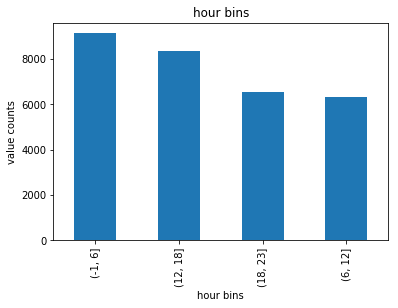

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

bins = [-1, 6, 12, 18, 23]
bin_hr = pd.cut(ddf['reported_hour'], bins)
bin_hr = bin_hr.cat.as_ordered()

bin_hr.value_counts().plot(kind='bar')
plt.title('hour bins')
plt.xlabel('hour bins')
plt.ylabel('value counts')

In [77]:

# now to afix this to our data frame and create dummies
ddf['time'] = bin_hr
ddf['time'] = ddf['time'].cat.codes
# Creating dummies
gbin_dummies = pd.get_dummies(bin_hr, prefix='hour') 

# keeping first column for now

ddf = ddf.drop(['time'], axis=1)
ddf = pd.concat([ddf, gbin_dummies], axis=1)
ddf.head()

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_gender,officer_race,subject_perceived_race,...,incident_month,officer_age,reported_hour,dif_race,dif_gender,dif_race_gender,"hour_(-1, 6]","hour_(6, 12]","hour_(12, 18]","hour_(18, 23]"
121,Unknown,unassigned,20150000110760,33273,Offense Report,None,6355,F,White,White,...,4,45,8,N,N,Y,0,1,0,0
122,Unknown,unassigned,20150000110760,33274,Offense Report,None,6355,F,White,White,...,4,45,8,N,Y,Y,0,1,0,0
123,Unknown,unassigned,20150000120532,35462,Non-Custodial Arrest,None,7735,M,White,Not Specified,...,4,24,16,Y,Y,Y,0,0,1,0
124,Unknown,unassigned,20150000127841,36993,Offense Report,None,7474,F,White,Not Specified,...,4,46,16,Y,Y,Y,0,0,1,0
126,Unknown,unassigned,20150000145811,41041,Non-Custodial Arrest,None,4835,M,White,Not Specified,...,5,56,16,Y,N,Y,0,0,1,0


In [78]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30364 entries, 121 to 43511
Data columns (total 31 columns):
subject_age_group           30364 non-null object
subject_id                  30364 non-null object
go_sc_num                   30364 non-null int64
terry_stop_id               30364 non-null int64
stop_resolution             30364 non-null object
weapon_type                 30364 non-null object
officer_id                  30364 non-null object
officer_gender              30364 non-null object
officer_race                30364 non-null object
subject_perceived_race      30364 non-null object
subject_perceived_gender    30364 non-null object
initial_call_type           30364 non-null object
final_call_type             30364 non-null object
call_type                   30364 non-null object
arrest_flag                 30364 non-null object
frisk_flag                  30364 non-null object
precinct                    30364 non-null object
sector                      30364 non-nul

In [79]:
ddf = ddf.rename(columns={'hour_(-1, 6]':'12am_6am', 
                          'hour_(6, 12]':'7am_12pm', 
                           'hour_(12, 18]':'1pm_6pm', 
                          'hour_(18, 23]':'7pm_11pm'})
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30364 entries, 121 to 43511
Data columns (total 31 columns):
subject_age_group           30364 non-null object
subject_id                  30364 non-null object
go_sc_num                   30364 non-null int64
terry_stop_id               30364 non-null int64
stop_resolution             30364 non-null object
weapon_type                 30364 non-null object
officer_id                  30364 non-null object
officer_gender              30364 non-null object
officer_race                30364 non-null object
subject_perceived_race      30364 non-null object
subject_perceived_gender    30364 non-null object
initial_call_type           30364 non-null object
final_call_type             30364 non-null object
call_type                   30364 non-null object
arrest_flag                 30364 non-null object
frisk_flag                  30364 non-null object
precinct                    30364 non-null object
sector                      30364 non-nul

In [80]:
# finally, drop reported hour
ddf = ddf.drop('reported_hour', axis=1)

Let's save what we have so far for EDA purposes.

In [81]:
ddf.to_csv('CSV_Files/eda_clean.csv')

## Cat Codes

In [82]:
def cat_codes(df, columns):
    """
    Input: Data frame and list of columns
    Output: Columns converted to categories and assigned cat_codes
    """
    for i in columns:
        df[i] = df[i].astype('category')
        df[i] = df[i].cat.codes

In [83]:
label_encoding = ['initial_call_type', 'final_call_type', 'precinct', 
               'incident_year', 'officer_age', 'officer_race', 
               'subject_perceived_race', 'call_type', 'sector', 'beat', 
                  'officer_id', 'stop_resolution', 'weapon_type']

In [84]:
cat_codes(ddf, label_encoding)

In [85]:
ddf.head()

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_gender,officer_race,subject_perceived_race,...,incident_year,incident_month,officer_age,dif_race,dif_gender,dif_race_gender,12am_6am,7am_12pm,1pm_6pm,7pm_11pm
121,Unknown,unassigned,20150000110760,33273,3,3,186,F,7,7,...,0,4,24,N,N,Y,0,1,0,0
122,Unknown,unassigned,20150000110760,33274,3,3,186,F,7,7,...,0,4,24,N,Y,Y,0,1,0,0
123,Unknown,unassigned,20150000120532,35462,2,3,615,M,7,5,...,0,4,3,Y,Y,Y,0,0,1,0
124,Unknown,unassigned,20150000127841,36993,3,3,414,F,7,5,...,0,4,25,Y,Y,Y,0,0,1,0
126,Unknown,unassigned,20150000145811,41041,2,3,11,M,7,5,...,0,5,35,Y,N,Y,0,0,1,0


In [86]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30364 entries, 121 to 43511
Data columns (total 30 columns):
subject_age_group           30364 non-null object
subject_id                  30364 non-null object
go_sc_num                   30364 non-null int64
terry_stop_id               30364 non-null int64
stop_resolution             30364 non-null int8
weapon_type                 30364 non-null int8
officer_id                  30364 non-null int16
officer_gender              30364 non-null object
officer_race                30364 non-null int8
subject_perceived_race      30364 non-null int8
subject_perceived_gender    30364 non-null object
initial_call_type           30364 non-null int16
final_call_type             30364 non-null int16
call_type                   30364 non-null int8
arrest_flag                 30364 non-null object
frisk_flag                  30364 non-null object
precinct                    30364 non-null int8
sector                      30364 non-null int8
beat    

## Dummy Variables
Time to create some dummy columns.

In [88]:
ddf.subject_age_group.value_counts()

26 - 35         10154
36 - 45          6361
18 - 25          6171
46 - 55          3833
56 and Above     1503
1 - 17           1473
Unknown           869
Name: subject_age_group, dtype: int64

Need to fix these values to avoid future issues.

In [90]:
replace_val(ddf, 'subject_age_group', ['26 - 35'], '26_35')
replace_val(ddf, 'subject_age_group', ['18 - 25'], '18_25')
replace_val(ddf, 'subject_age_group', ['36 - 45'], '36_45')
replace_val(ddf, 'subject_age_group', ['46 - 55'], '46_55')
replace_val(ddf, 'subject_age_group', ['56 and Above'], '56_up')
replace_val(ddf, 'subject_age_group', ['1 - 17'], '1_17')


In [92]:
ddf.subject_age_group.value_counts()

26_35      10154
36_45       6361
18_25       6171
46_55       3833
56_up       1503
1_17        1473
Unknown      869
Name: subject_age_group, dtype: int64

In [93]:
# Listing all of the columns to make dummies from
dummy = ['officer_gender', 'subject_perceived_gender', 'arrest_flag', 
           'frisk_flag', 'dif_race', 'dif_gender', 'dif_race_gender', 
           'repeat_offenders', 'subject_age_group']

In [94]:
# for loop to iterate through list and concat them to the data frame
for col in dummy:
    dumdums = pd.get_dummies(ddf[str(col)], drop_first=True, prefix=f'{col}_') 
    ddf = pd.concat([ddf, dumdums], axis=1)
    ddf = ddf.drop(col, axis=1)

In [95]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30364 entries, 121 to 43511
Data columns (total 35 columns):
subject_id                                       30364 non-null object
go_sc_num                                        30364 non-null int64
terry_stop_id                                    30364 non-null int64
stop_resolution                                  30364 non-null int8
weapon_type                                      30364 non-null int8
officer_id                                       30364 non-null int16
officer_race                                     30364 non-null int8
subject_perceived_race                           30364 non-null int8
initial_call_type                                30364 non-null int16
final_call_type                                  30364 non-null int16
call_type                                        30364 non-null int8
precinct                                         30364 non-null int8
sector                                           30364

Awesome! Let's drop the ID columns and export this thing!

In [96]:
ddf = ddf.drop(['subject_id', 'go_sc_num', 'terry_stop_id'], axis=1)

In [97]:
ddf.columns

Index(['stop_resolution', 'weapon_type', 'officer_id', 'officer_race',
       'subject_perceived_race', 'initial_call_type', 'final_call_type',
       'call_type', 'precinct', 'sector', 'beat', 'incident_year',
       'incident_month', 'officer_age', '12am_6am', '7am_12pm', '1pm_6pm',
       '7pm_11pm', 'officer_gender__M', 'subject_perceived_gender__M',
       'subject_perceived_gender__Unable to Determine', 'arrest_flag__Y',
       'frisk_flag__Y', 'dif_race__Y', 'dif_gender__Y', 'repeat_offenders__Y',
       'subject_age_group__1_17', 'subject_age_group__26_35',
       'subject_age_group__36_45', 'subject_age_group__46_55',
       'subject_age_group__56_up', 'subject_age_group__Unknown'],
      dtype='object')

# Export to CSV
Ok! Finally finished with preprocessing! Time to save this to a new CSV!

In [98]:
ddf.to_csv('CSV_Files/Terry_Stops_with_dummies.csv')